In [4]:
import os
os.getcwd()
os.chdir("C:\Data")
os.getcwd()

'C:\\Data'

In [5]:
pip install skimpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from pyearth import Earth
from sklearn.metrics import (mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve, make_scorer,
                             recall_score, accuracy_score, precision_score, confusion_matrix)
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, StratifiedKFold,
                                     GridSearchCV, ParameterGrid)
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import (BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, 
                              GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier, 
                              VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier)
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import xgboost as xgb
import time as time
import random
from skimpy import clean_columns

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus

# Importing and Cleaning Data

In [7]:
data = pd.read_csv('heart_2020_cleaned.csv')
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [8]:
print(data.isnull().values.any())
data.dtypes

False


HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

In [9]:
#convert age to numerical
import re
ages = list(data['AgeCategory'].unique())
ages = [re.findall(r'\d+', i) for i in ages]
ages = [[int(j) for j in i] for i in ages]
mean_ages = [np.array(i).mean() for i in ages]
ranges = data['AgeCategory'].unique()
d = {}
for i in range(len(mean_ages)):
    d[ranges[i]] = mean_ages[i]
print(d)
data['Age'] = data['AgeCategory'].apply(lambda x: d[x])

{'55-59': 57.0, '80 or older': 80.0, '65-69': 67.0, '75-79': 77.0, '40-44': 42.0, '70-74': 72.0, '60-64': 62.0, '50-54': 52.0, '45-49': 47.0, '18-24': 21.0, '35-39': 37.0, '30-34': 32.0, '25-29': 27.0}


In [10]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Age
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,57.0
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,80.0
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,67.0
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,77.0
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,42.0


In [11]:
pd.get_dummies(data).corr()['HeartDisease_Yes'].sort_values()

HeartDisease_No                       -1.000000
DiffWalking_No                        -0.201258
Stroke_No                             -0.196835
Diabetic_No                           -0.170977
KidneyDisease_No                      -0.145197
GenHealth_Excellent                   -0.116042
Smoking_No                            -0.107764
GenHealth_Very good                   -0.101886
PhysicalActivity_Yes                  -0.100030
SkinCancer_No                         -0.093317
AgeCategory_18-24                     -0.075385
Sex_Female                            -0.070040
AgeCategory_35-39                     -0.066685
AgeCategory_25-29                     -0.065759
AgeCategory_30-34                     -0.065611
AgeCategory_40-44                     -0.059196
AgeCategory_45-49                     -0.049733
Asthma_No                             -0.041444
Race_Hispanic                         -0.036163
AgeCategory_50-54                     -0.032648
AlcoholDrinking_Yes                   -0

In [12]:
data_dum = data.drop(columns = ['SleepTime', 'AgeCategory'])
data_dum = pd.get_dummies(data_dum)
data_dum.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'Age', 'HeartDisease_No',
       'HeartDisease_Yes', 'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'Stroke_No', 'Stroke_Yes', 'DiffWalking_No',
       'DiffWalking_Yes', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White', 'Diabetic_No',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'PhysicalActivity_No',
       'PhysicalActivity_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good', 'Asthma_No',
       'Asthma_Yes', 'KidneyDisease_No', 'KidneyDisease_Yes', 'SkinCancer_No',
       'SkinCancer_Yes'],
      dtype='object')

In [13]:
no_var = []

for col in list(pd.get_dummies(data_dum).columns):
    if col.endswith('_No'):
        no_var.append(col)
        
no_var

['HeartDisease_No',
 'Smoking_No',
 'AlcoholDrinking_No',
 'Stroke_No',
 'DiffWalking_No',
 'Diabetic_No',
 'PhysicalActivity_No',
 'Asthma_No',
 'KidneyDisease_No',
 'SkinCancer_No']

In [14]:
#reducing levels of categorical predictors
data_dum = data_dum.drop(columns = no_var)
data_dum = data_dum.drop(columns = ['Sex_Female', 'Race_American Indian/Alaskan Native', 
                                    'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 
                                    'Diabetic_No, borderline diabetes', 'Diabetic_Yes (during pregnancy)'])
data_dum.head()

,BMI,PhysicalHealth,MentalHealth,Age,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,16.60,3.0,30.0,57.0,0,1,0,0,0,0,...,1,1,0,0,0,0,1,1,0,1
1,20.34,0.0,0.0,80.0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,26.58,20.0,30.0,67.0,0,1,0,0,0,1,...,1,1,0,1,0,0,0,1,0,0
3,24.21,0.0,0.0,77.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,23.71,28.0,0.0,42.0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


In [15]:
#didn't end up using skimpy since that made everything lowercase
data_dum.columns = data_dum.columns.str.replace(' ', '_')
data_dum.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'Age', 'HeartDisease_Yes',
       'Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes', 'DiffWalking_Yes',
       'Sex_Male', 'Race_White', 'Diabetic_Yes', 'PhysicalActivity_Yes',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very_good', 'Asthma_Yes',
       'KidneyDisease_Yes', 'SkinCancer_Yes'],
      dtype='object')

In [16]:
#Balancing positive and negative responses
yes = data_dum[data_dum['HeartDisease_Yes'] == 1]
print(yes.shape)
yes.head()

(27373, 21)


,BMI,PhysicalHealth,MentalHealth,Age,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very_good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
5,28.87,6.0,0.0,77.0,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
10,34.30,30.0,0.0,62.0,1,1,0,0,1,1,...,1,0,0,0,0,1,0,1,0,0
35,32.98,10.0,0.0,77.0,1,1,0,1,1,1,...,1,1,0,0,0,1,0,0,0,1
42,25.06,0.0,0.0,80.0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
43,30.23,6.0,2.0,77.0,1,1,0,0,1,0,...,1,1,0,1,0,0,0,0,1,0


In [17]:
no = data_dum[data_dum['HeartDisease_Yes'] == 0]
print(no.shape)
no = no.sample(n = 27373)
print(no.shape)
no.head()

(292422, 21)
(27373, 21)


,BMI,PhysicalHealth,MentalHealth,Age,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very_good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
241662,36.61,0.0,30.0,47.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
119618,27.89,0.0,0.0,42.0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
5352,27.44,0.0,3.0,67.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
29156,19.97,3.0,0.0,32.0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
243296,45.19,0.0,15.0,32.0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [18]:
data_balanced = pd.concat([no, yes], ignore_index = True)
print(data_balanced.shape)
data_balanced.head()

(54746, 21)


,BMI,PhysicalHealth,MentalHealth,Age,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very_good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,36.61,0.0,30.0,47.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,27.89,0.0,0.0,42.0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,27.44,0.0,3.0,67.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,19.97,3.0,0.0,32.0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,45.19,0.0,15.0,32.0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [19]:
X = data_balanced.drop(columns = 'HeartDisease_Yes')
X.head()

,BMI,PhysicalHealth,MentalHealth,Age,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,Race_White,Diabetic_Yes,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very_good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,36.61,0.0,30.0,47.0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
1,27.89,0.0,0.0,42.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
2,27.44,0.0,3.0,67.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,19.97,3.0,0.0,32.0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
4,45.19,0.0,15.0,32.0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0


In [20]:
y = data_balanced.HeartDisease_Yes
y.head()

0    0
1    0
2    0
3    0
4    0
Name: HeartDisease_Yes, dtype: uint8

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 4000, test_size = 1000, random_state = 1, stratify = y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, train_size = 4000, test_size = 1000, random_state = 2, stratify = y)

In [22]:
#Checking to make sure responses are still balanced
print(y_train.value_counts())
print(y_test.value_counts())
print(y_train2.value_counts())
print(y_test2.value_counts())

0    2000
1    2000
Name: HeartDisease_Yes, dtype: int64
0    500
1    500
Name: HeartDisease_Yes, dtype: int64
0    2000
1    2000
Name: HeartDisease_Yes, dtype: int64
0    500
1    500
Name: HeartDisease_Yes, dtype: int64


In [23]:
#Checking if X_train and X_train2 overlap
np.unique([X_train.index.values == X_train2.index.values], return_counts = True)

(array([False]), array([4000], dtype=int64))

In [24]:
X_train.head()

,BMI,PhysicalHealth,MentalHealth,Age,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,Race_White,Diabetic_Yes,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very_good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
16548,30.34,0.0,0.0,67.0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
1305,25.83,0.0,0.0,72.0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0
8061,23.71,0.0,0.0,77.0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1
20173,32.93,20.0,3.0,62.0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0
44566,24.11,0.0,0.0,77.0,1,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0


# Functions

In [25]:
#Function to compute confusion matrix and prediction accuracy on test/train data using tree models
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
#    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize = (8, 8))
    plt.title('Precision and Recall Scores as a function of the decision threshold')
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc = 'best')

In [27]:
def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [28]:
def confusion_matrix_train(model, cutoff = 0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'}) 
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    #print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")
    return cm_df, accuracy

In [29]:
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix_test(data,actual_values,model,cutoff=0.5): #Predict the values using the Logit model
    pred_values = model.predict(data) # Specify the bins
    bins=np.array([0,cutoff,1]) #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    # Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum() # Return the confusion matrix and the accuracy
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    #print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

# Classification Tree

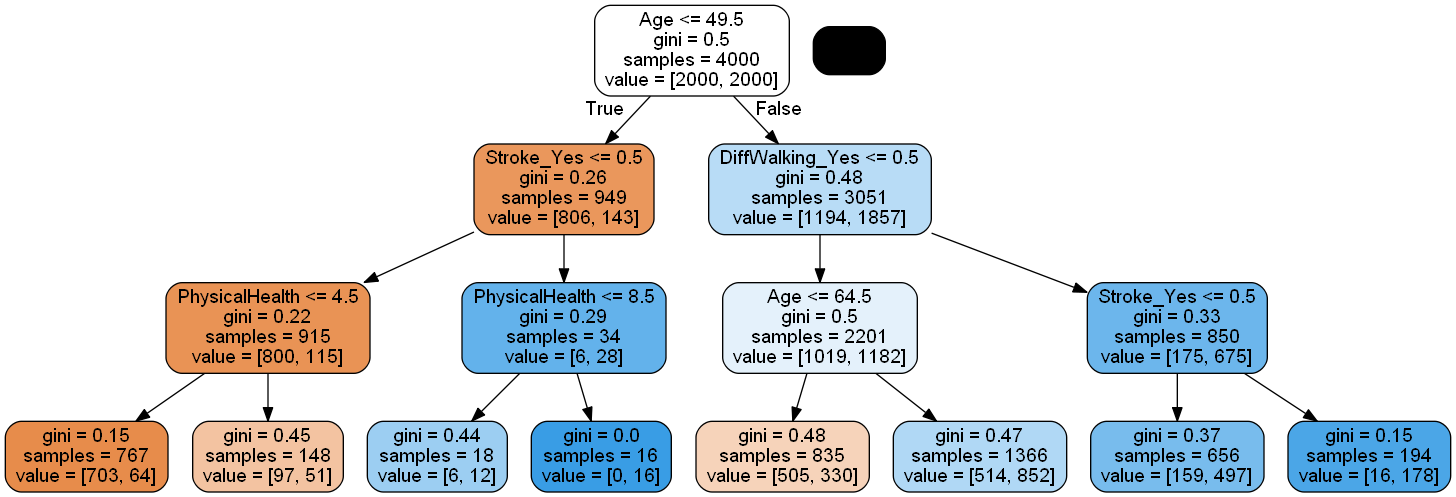

In [34]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1, max_depth=3)

#Fitting the regression tree to the data
model.fit(X_train, y_train)

#Visualizing the regression tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
filled=True, rounded=True,
feature_names = X_train.columns,precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('car_price_tree.png')
Image(graph.create_png())

In [35]:
pred=model.predict_proba(X_test)[:,0]
confusion_matrix_data(X_train,y_train,model,cutoff=0.4)

Accuracy =  71.5
Precision =  69.11111111111111
FNR =  22.25
TPR or Recall =  77.75
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1305.0        695.0
Actual 1        445.0       1555.0


' '

In [39]:
#Defining parameters and the range of values over which to optimize
param_grid = {
'max_depth': range(1,10),
'max_leaf_nodes': range(10,30),
}

skf = StratifiedKFold(n_splits=5)
#The folds are made by preserving the percentage of samples for each class.
#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, 
                           scoring=['precision','recall','accuracy'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)
# make the predictions
y_pred = grid_search.predict(X_test)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best params for recall
{'max_depth': 2, 'max_leaf_nodes': 10}


In [46]:
#All results of the grid search can be seen with cv_results_
cv_scores = pd.DataFrame(grid_search.cv_results_)

model = DecisionTreeClassifier(random_state=1, max_depth = 5, max_leaf_nodes=25)
model.fit(X_train,y_train)
print(confusion_matrix_data(X_train,y_train,model))
print(confusion_matrix_data(X_test,y_test,model))
print(confusion_matrix_data(X_train,y_train,model,cutoff=0.2))
print(confusion_matrix_data(X_test,y_test,model,cutoff=0.2))

Accuracy =  74.2
Precision =  72.83018867924528
FNR =  22.8
TPR or Recall =  77.2
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1424.0        576.0
Actual 1        456.0       1544.0
 
Accuracy =  72.5
Precision =  70.49180327868852
FNR =  22.6
TPR or Recall =  77.4
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        338.0        162.0
Actual 1        113.0        387.0
 
Accuracy =  65.925
Precision =  59.77293648358392
FNR =  2.6
TPR or Recall =  97.4
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        689.0       1311.0
Actual 1         52.0       1948.0
 
Accuracy =  66.5
Precision =  60.19777503090235
FNR =  2.6
TPR or Recall =  97.4
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        178.0        322.0
Actual 1         13.0        487.0
 


In [56]:
clf = DecisionTreeClassifier(random_state=1)
param_grid = {
'max_depth': range(1,10),
'max_leaf_nodes': range(10,30),
'max_features': range(3,8)
}

refit_score = "roc_auc"

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid,scoring=['precision','recall','accuracy','roc_auc'], 
                           refit=refit_score,cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for', refit_score)
print(grid_search.best_params_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best params for roc_auc
{'max_depth': 7, 'max_features': 5, 'max_leaf_nodes': 28}


In [57]:
model = DecisionTreeClassifier(random_state=1, max_depth = 7, max_leaf_nodes = 28, max_features = 5)
model.fit(X_train,y_train)
print(confusion_matrix_data(X_train,y_train,model))
print(confusion_matrix_data(X_test,y_test,model))
print(confusion_matrix_data(X_train,y_train,model,cutoff=0.2))
print(confusion_matrix_data(X_test,y_test,model,cutoff=0.2))

Accuracy =  75.425
Precision =  72.8744939271255
FNR =  19.0
TPR or Recall =  81.0
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1397.0        603.0
Actual 1        380.0       1620.0
 
Accuracy =  74.1
Precision =  71.63375224416517
FNR =  20.2
TPR or Recall =  79.8
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        342.0        158.0
Actual 1        101.0        399.0
 
Accuracy =  66.725
Precision =  60.44985941893158
FNR =  3.25
TPR or Recall =  96.75
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        734.0       1266.0
Actual 1         65.0       1935.0
 
Accuracy =  67.3
Precision =  61.10397946084724
FNR =  4.8
TPR or Recall =  95.2
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        197.0        303.0
Actual 1         24.0        476.0
 


In [36]:
model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X_train,y_train)# Compute the pruning path during Minimal Cost-Complexity Pruning.
alphas=path['ccp_alphas']
len(alphas)

408

In [58]:
#Grid search to optimize parameter values
param_grid = {
'ccp_alpha':alphas,
}

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 408 candidates, totalling 2040 fits
Best params for recall
{'ccp_alpha': 0.020264403994903202}


In [59]:
tree = DecisionTreeClassifier(ccp_alpha=0.020264403994903202,random_state=1)
tree.fit(X_train, y_train)
print(confusion_matrix_data(X_train,y_train,tree))
print(confusion_matrix_data(X_test,y_pred,tree))
print(confusion_matrix_data(X_train,y_train,model,cutoff=0.2))
print(confusion_matrix_data(X_test,y_pred,model,cutoff=0.2))

Accuracy =  66.575
Precision =  60.86529006882989
FNR =  7.15
TPR or Recall =  92.85
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        806.0       1194.0
Actual 1        143.0       1857.0
 
Accuracy =  100.0
Precision =  100.0
FNR =  0.0
TPR or Recall =  100.0
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        229.0          0.0
Actual 1          0.0        771.0
 
Accuracy =  66.725
Precision =  60.44985941893158
FNR =  3.25
TPR or Recall =  96.75
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        734.0       1266.0
Actual 1         65.0       1935.0
 
Accuracy =  93.6
Precision =  95.37869062901156
FNR =  3.6316472114137484
TPR or Recall =  96.36835278858625
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        193.0         36.0
Actual 1         28.0        743.0
 


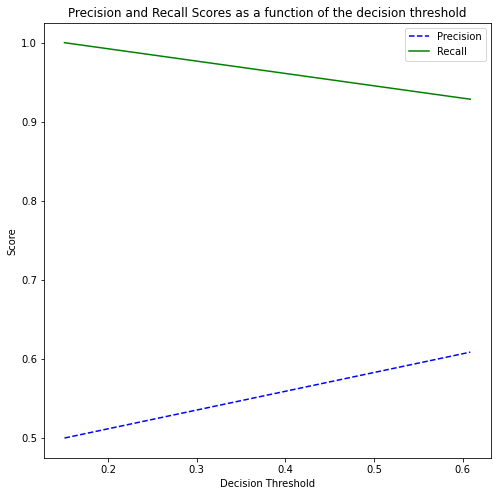

In [60]:
ypred = tree.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)

plot_precision_recall_vs_threshold(p, r, thresholds)

# Exploratory Data Analysis

<AxesSubplot:xlabel='HeartDisease', ylabel='Count'>

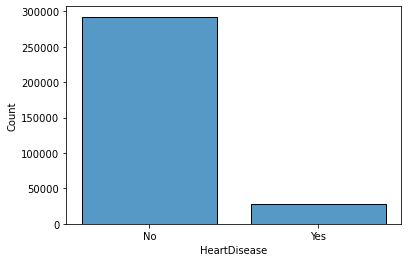

In [243]:
sns.histplot(data = data, x = 'HeartDisease', shrink = 0.8)

- There are many more negative samples, so precision-recall is appropriate

<AxesSubplot:xlabel='Race', ylabel='Count'>

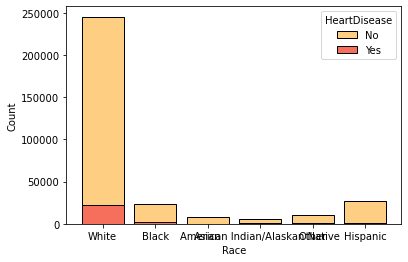

In [89]:
sns.histplot(x = "Race", hue = "HeartDisease", data = data, 
             stat = "count", shrink = 0.8, multiple = 'stack', palette="YlOrRd")

<AxesSubplot:xlabel='Diabetic', ylabel='Count'>

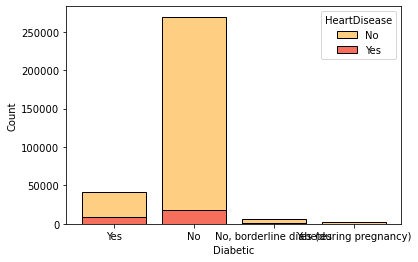

In [90]:
sns.histplot(x = "Diabetic", hue = "HeartDisease", data = data, 
             stat = "count", shrink = 0.8, multiple = 'stack', palette="YlOrRd")

<AxesSubplot:xlabel='GenHealth', ylabel='Count'>

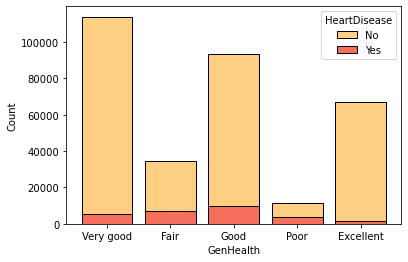

In [93]:
sns.histplot(x = "GenHealth", hue = "HeartDisease", data = data, 
             stat = "count", shrink = 0.8, multiple = 'stack', palette="YlOrRd")

<AxesSubplot:xlabel='HeartDisease_Yes', ylabel='BMI'>

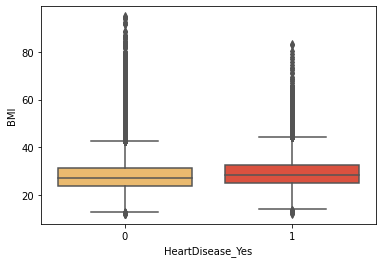

In [153]:
sns.boxplot(x="HeartDisease_Yes", y="BMI", data=data_dum, palette='YlOrRd')

<AxesSubplot:xlabel='BMI', ylabel='Density'>

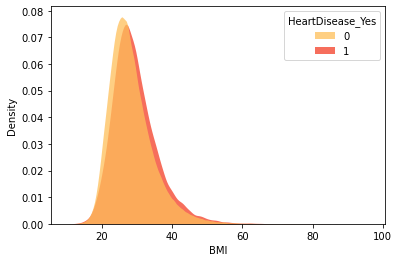

In [154]:
sns.kdeplot(
   data=data_dum, x="BMI", hue="HeartDisease_Yes",
   fill=True, common_norm=False, palette="YlOrRd",
    linewidth=0, alpha=.75
)

<AxesSubplot:xlabel='HeartDisease_Yes', ylabel='PhysicalHealth'>

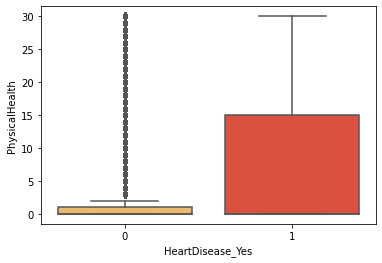

In [98]:
sns.boxplot(x="HeartDisease_Yes", y="PhysicalHealth", data=data_dum, palette='YlOrRd')

<AxesSubplot:xlabel='HeartDisease_Yes', ylabel='MentalHealth'>

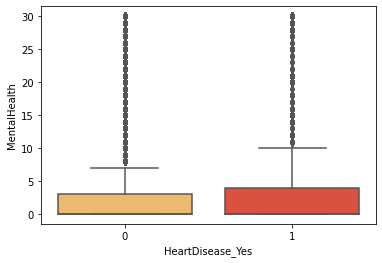

In [99]:
sns.boxplot(x="HeartDisease_Yes", y="MentalHealth", data=data_dum, palette='YlOrRd')

<AxesSubplot:xlabel='Age', ylabel='BMI'>

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


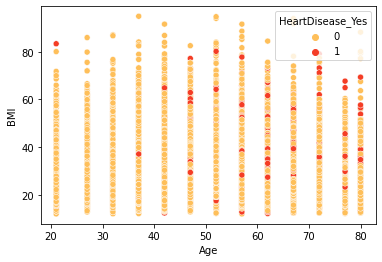

In [156]:
sns.scatterplot(data=data_dum, x="Age", y="BMI", hue="HeartDisease_Yes", palette='YlOrRd')

<AxesSubplot:xlabel='Age', ylabel='Count'>

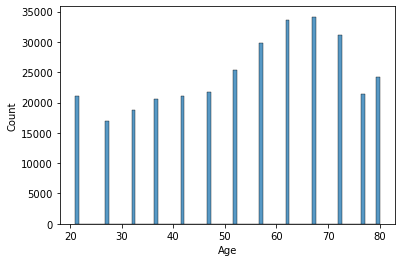

In [240]:
sns.histplot(data=data, x = "Age", stat = 'count', palette = "YlOrRd")

<AxesSubplot:xlabel='Age', ylabel='HeartDisease_Yes'>

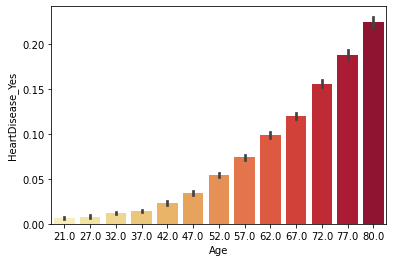

In [158]:
sns.barplot(data=data_dum, x="Age", y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='Stroke_Yes', ylabel='HeartDisease_Yes'>

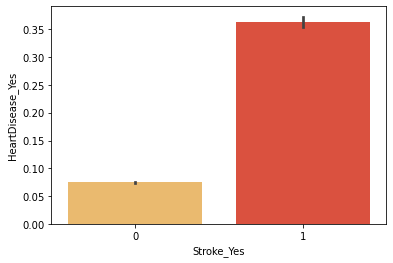

In [159]:
sns.barplot(data=data_dum, x="Stroke_Yes", y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='Diabetic_Yes', ylabel='HeartDisease_Yes'>

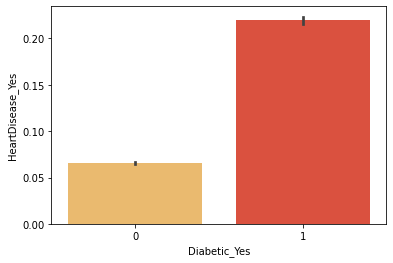

In [160]:
sns.barplot(data=data_dum, x="Diabetic_Yes", y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='Smoking_Yes', ylabel='HeartDisease_Yes'>

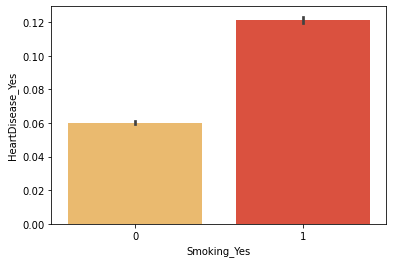

In [100]:
sns.barplot(data=data_dum, x="Smoking_Yes", y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='Sex_Male', ylabel='HeartDisease_Yes'>

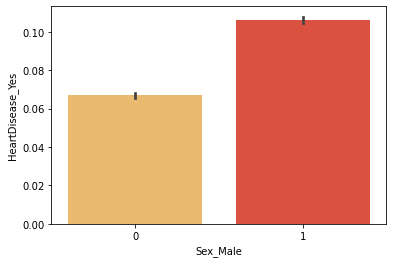

In [149]:
sns.barplot(data=data_dum, x = 'Sex_Male', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='AlcoholDrinking_Yes', ylabel='HeartDisease_Yes'>

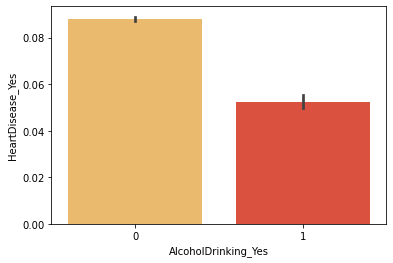

In [150]:
sns.barplot(data=data_dum, x = 'AlcoholDrinking_Yes', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='DiffWalking_Yes', ylabel='HeartDisease_Yes'>

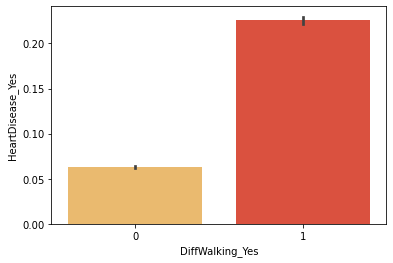

In [151]:
sns.barplot(data=data_dum, x = 'DiffWalking_Yes', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='Diabetic_Yes', ylabel='HeartDisease_Yes'>

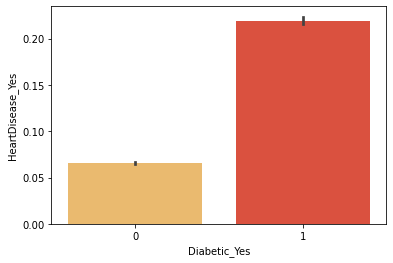

In [152]:
sns.barplot(data=data_dum, x = 'Diabetic_Yes', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='PhysicalActivity_Yes', ylabel='HeartDisease_Yes'>

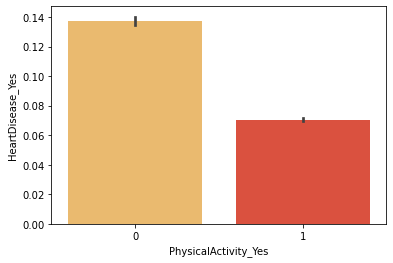

In [153]:
sns.barplot(data=data_dum, x = 'PhysicalActivity_Yes', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='Asthma_Yes', ylabel='HeartDisease_Yes'>

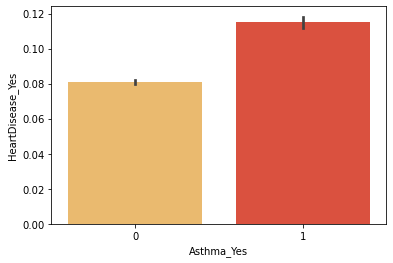

In [154]:
sns.barplot(data=data_dum, x = 'Asthma_Yes', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='KidneyDisease_Yes', ylabel='HeartDisease_Yes'>

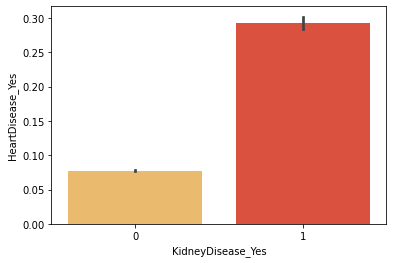

In [156]:
sns.barplot(data=data_dum, x = 'KidneyDisease_Yes', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='SkinCancer_Yes', ylabel='HeartDisease_Yes'>

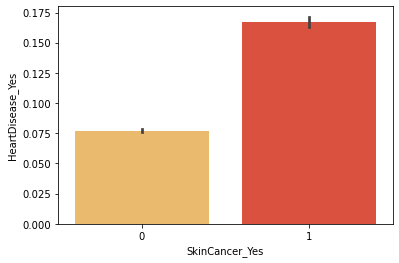

In [157]:
sns.barplot(data=data_dum, x = 'SkinCancer_Yes', y = 'HeartDisease_Yes', palette = "YlOrRd")

<AxesSubplot:xlabel='Race_White', ylabel='HeartDisease_Yes'>

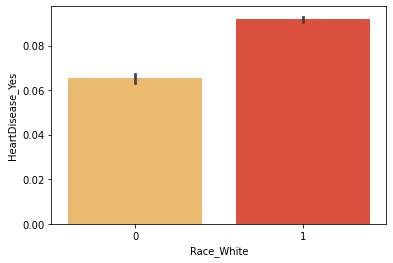

In [182]:
sns.barplot(data=data_dum, x = 'Race_White', y = 'HeartDisease_Yes', palette = "YlOrRd")

([<matplotlib.axis.XTick at 0x1ca0855fee0>,
 [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

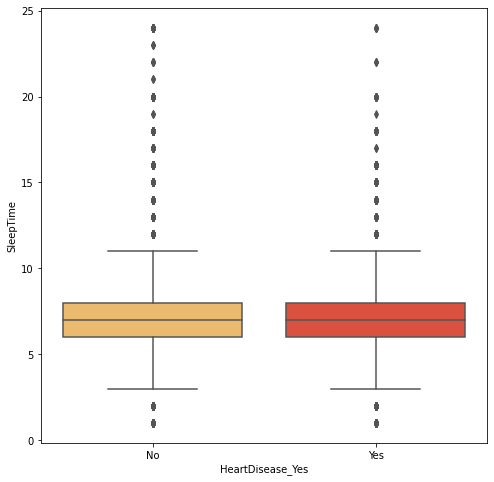

In [161]:
fig, axes = plt.subplots(1, 1, figsize = (8,8))

p2 = sns.boxplot(data = data_dum, x = 'HeartDisease_Yes', y = 'SleepTime', palette = 'YlOrRd')

p2.set_title("")
plt.xticks([0,1],['No','Yes'])

# Simple Logistic Regression

In [162]:
train = pd.concat([X_train, y_train], axis=1, join="inner")
train.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Female,Sex_Male,...,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very_good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes,HeartDisease_Yes
291133,24.53,2,0,6,1,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
309330,33.00,0,0,7,1,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
307280,27.60,0,5,9,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
7469,28.70,0,14,8,1,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
33630,28.98,0,0,7,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1


In [163]:
test = pd.concat([X_test, y_test], axis=1, join="inner")
test.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Female,Sex_Male,...,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very_good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes,HeartDisease_Yes
301988,24.30,0,15,7,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
223127,23.78,0,0,7,1,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,1
216797,20.60,0,0,7,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
234217,28.29,0,20,4,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
30822,33.00,0,0,8,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1


In [164]:
train.dtypes

BMI                                    float64
PhysicalHealth                           int64
MentalHealth                             int64
SleepTime                                int64
Smoking_Yes                              uint8
AlcoholDrinking_Yes                      uint8
Stroke_Yes                               uint8
DiffWalking_Yes                          uint8
Sex_Female                               uint8
Sex_Male                                 uint8
AgeCategory_18_24                        uint8
AgeCategory_25_29                        uint8
AgeCategory_30_34                        uint8
AgeCategory_35_39                        uint8
AgeCategory_40_44                        uint8
AgeCategory_45_49                        uint8
AgeCategory_50_54                        uint8
AgeCategory_55_59                        uint8
AgeCategory_60_64                        uint8
AgeCategory_65_69                        uint8
AgeCategory_70_74                        uint8
AgeCategory_7

In [165]:
test.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Smoking_Yes',
       'AlcoholDrinking_Yes', 'Stroke_Yes', 'DiffWalking_Yes', 'Sex_Female',
       'Sex_Male', 'AgeCategory_18_24', 'AgeCategory_25_29',
       'AgeCategory_30_34', 'AgeCategory_35_39', 'AgeCategory_40_44',
       'AgeCategory_45_49', 'AgeCategory_50_54', 'AgeCategory_55_59',
       'AgeCategory_60_64', 'AgeCategory_65_69', 'AgeCategory_70_74',
       'AgeCategory_75_79', 'AgeCategory_80_or_older',
       'Race_American_Indian_Alaskan_Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No_borderline_diabetes', 'Diabetic_Yes',
       'Diabetic_Yes_during_pregnancy', 'PhysicalActivity_Yes',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very_good', 'Asthma_Yes',
       'KidneyDisease_Yes', 'SkinCancer_Yes', 'HeartDisease_Yes'],
      dtype='object')

In [166]:
formula = ols_formula(train, "HeartDisease_Yes")
log_model = smf.logit(formula = formula, data = train).fit()
log_model.summary()

         Current function value: 0.227795
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       HeartDisease_Yes   No. Observations:               255836
Model:                          Logit   Df Residuals:                   255798
Method:                           MLE   Df Model:                           37
Date:                Mon, 16 May 2022   Pseudo R-squ.:                  0.2227
Time:                        18:16:41   Log-Likelihood:                -58278.
converged:                      False   LL-Null:                       -74974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -2.5441        nan        nan        nan         nan         nan
BMI                                     0.0092      0.001      7.203      0.000       0.007       0.012
PhysicalHealth                          0.0031      0.001      3.213      0.001       0.001       0.005
MentalHealth                            0.0047      0.001      4.753      0.000       0.003       0.007
SleepTime                              -0.0266      0.005     -5.484      0.000      -0.036      -0.017
Smoking_Yes                             0.3518      0.016     21.952      0.000       0.320       0.383
AlcoholDrinking_Yes                    -0.2325      0.037     -6.232      0.000      -0.306      -0.159
Stroke_Yes                              1.0674      0.025     42.298      0.000       1.018       1.117
DiffWalking_Yes                         0.2128      0.020     10.498      0.000       0.173       0.253
Sex_Female                             -0.2140        nan        nan        nan         nan         nan
Sex_Male                                0.4948        nan        nan        nan         nan         nan
AgeCategory_18_24                      -1.7655   6.69e+05  -2.64e-06      1.000   -1.31e+06    1.31e+06
AgeCategory_25_29                      -1.5392    6.7e+05   -2.3e-06      1.000   -1.31e+06    1.31e+06
AgeCategory_30_34                      -1.2166    6.7e+05  -1.82e-06      1.000   -1.31e+06    1.31e+06
AgeCategory_35_39                      -1.1732   6.72e+05  -1.75e-06      1.000   -1.32e+06    1.32e+06
AgeCategory_40_44                      -0.7311   6.69e+05  -1.09e-06      1.000   -1.31e+06    1.31e+06
AgeCategory_45_49                      -0.4004   6.71e+05  -5.96e-07      1.000   -1.32e+06    1.32e+06
AgeCategory_50_54                      -0.0008    6.7e+05  -1.26e-09      1.000   -1.31e+06    1.31e+06
AgeCategory_55_59                       0.2437   6.71e+05   3.63e-07      1.000   -1.31e+06    1.31e+06
AgeCategory_60_64                       0.5221   6.69e+05   7.81e-07      1.000   -1.31e+06    1.31e+06
AgeCategory_65_69                       0.7508   6.71e+05   1.12e-06      1.000   -1.32e+06    1.32e+06
AgeCategory_70_74                       1.0451   6.72e+05   1.55e-06      1.000   -1.32e+06    1.32e+06
AgeCategory_75_79                       1.2395    6.7e+05   1.85e-06      1.000   -1.31e+06    1.31e+06
AgeCategory_80_or_older                 1.4998   6.71e+05   2.24e-06      1.000   -1.32e+06    1.32e+06
Race_American_Indian_Alaskan_Native    -0.4505        nan        nan        nan         nan         nan
Race_Asian                             -0.9895        nan        nan        nan         nan         nan
Race_Black                             -0.8017        nan        nan        nan         nan         nan
Race_Hispanic                          -0.7244        nan        nan        nan         nan         nan
Race_Other       

**Questions**
- Why are GenHealth, Race, Sex P-values equal to nan? perfect multicollinearity
- exclude one of the dummy variables

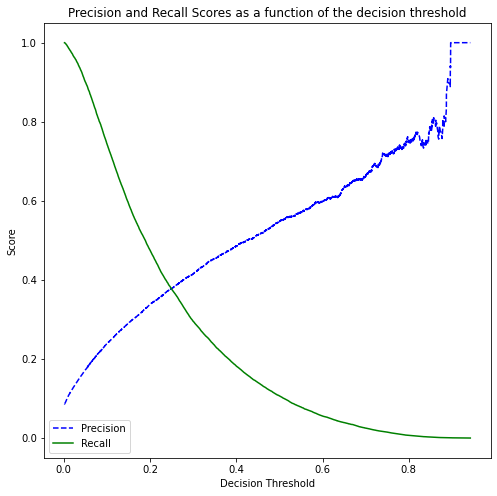

In [167]:
ypred = log_model.predict(train)
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [168]:
confusion_matrix_train(log_model, 0.2)

Accuracy =  87.50762207038885
Precision =  33.84420970773119
FNR =  52.49681644533382
TPR or Recall =  47.50318355466618
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     213431.0      20417.0
Actual 1      11543.0      10445.0


' '

In [169]:
confusion_matrix_test(test,test.HeartDisease_Yes,log_model, 0.2)

Accuracy =  87.59830516424584
Precision =  33.696069645371914
FNR =  51.12349117920149
TPR or Recall =  48.87650882079851
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     213431.0      20417.0
Actual 1      11543.0      10445.0


' '

# Classification Tree

In [175]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1, max_depth=5)

#Fitting the regression tree to the data
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

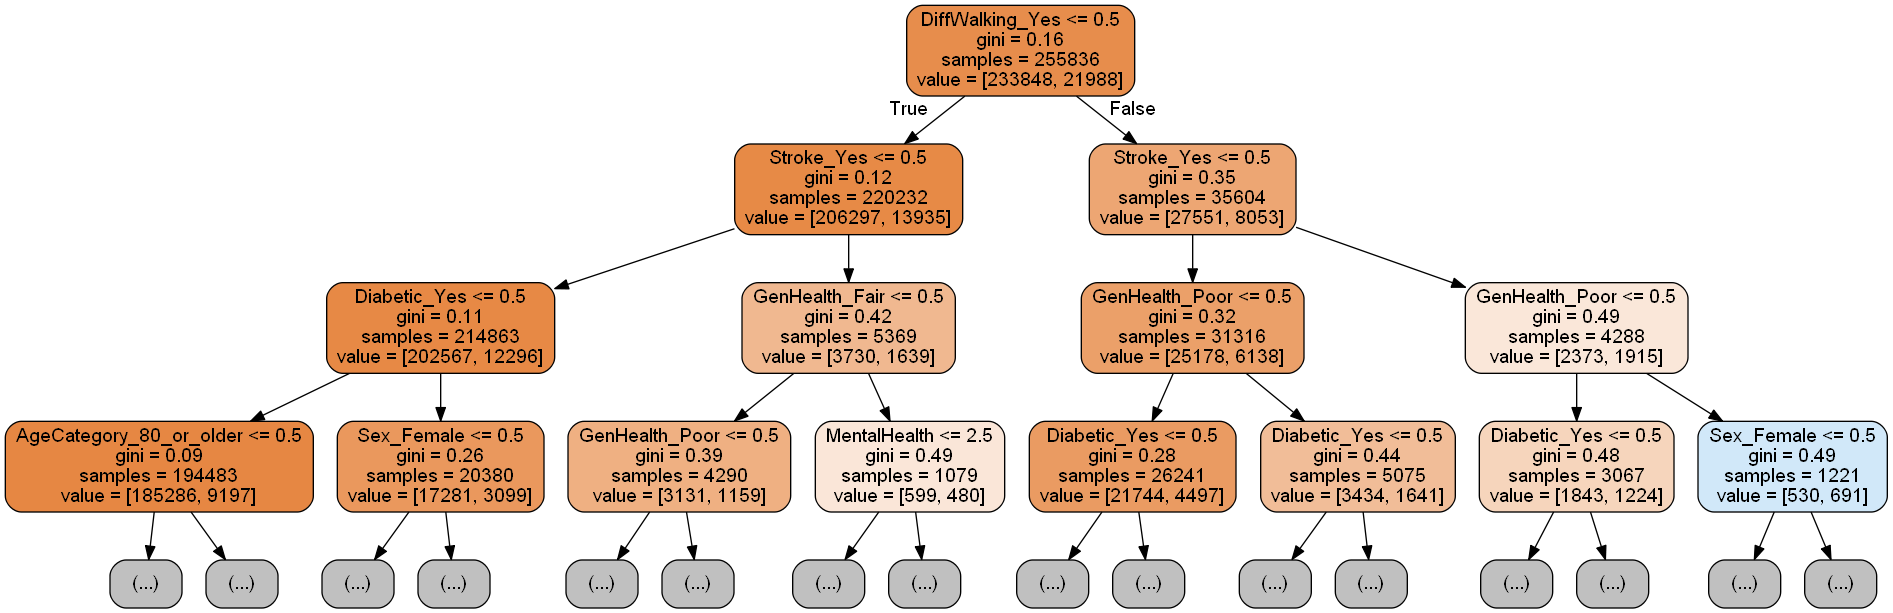

In [176]:
#Visualizing the regression tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
                filled=True, rounded=True, max_depth = 3, 
                feature_names = X_train.columns,precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('car_price_tree.png')
Image(graph.create_png())

In [177]:
confusion_matrix_data(X_train,y_train,model,cutoff=0.4)

Accuracy =  91.41129473569005
Precision =  50.149730485126774
FNR =  88.57558668364562
TPR or Recall =  11.424413316354375
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     231351.0       2497.0
Actual 1      19476.0       2512.0


' '

In [178]:
X_train.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Smoking_Yes',
       'AlcoholDrinking_Yes', 'Stroke_Yes', 'DiffWalking_Yes', 'Sex_Female',
       'Sex_Male', 'AgeCategory_18_24', 'AgeCategory_25_29',
       'AgeCategory_30_34', 'AgeCategory_35_39', 'AgeCategory_40_44',
       'AgeCategory_45_49', 'AgeCategory_50_54', 'AgeCategory_55_59',
       'AgeCategory_60_64', 'AgeCategory_65_69', 'AgeCategory_70_74',
       'AgeCategory_75_79', 'AgeCategory_80_or_older',
       'Race_American_Indian_Alaskan_Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No_borderline_diabetes', 'Diabetic_Yes',
       'Diabetic_Yes_during_pregnancy', 'PhysicalActivity_Yes',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very_good', 'Asthma_Yes',
       'KidneyDisease_Yes', 'SkinCancer_Yes'],
      dtype='object')

In [179]:
#Defining parameters and the range of values over which to optimize
param_grid = {
    'max_depth': range(1,10),
    'max_leaf_nodes': range(10,30),
}

skf = StratifiedKFold(n_splits=5)
#The folds are made by preserving the percentage of samples for each class.
#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, 
                           scoring=['precision','recall','accuracy'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train.iloc[:10000, :], y_train.iloc[:10000])
# make the predictions
y_pred = grid_search.predict(X_test)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best params for recall
{'max_depth': 5, 'max_leaf_nodes': 27}


In [180]:
#All results of the grid search can be seen with cv_results_
cv_scores = pd.DataFrame(grid_search.cv_results_)

model = DecisionTreeClassifier(random_state=1, max_depth = 5, max_leaf_nodes=27)
model.fit(X_train,y_train)
print(confusion_matrix_data(X_train,y_train,model))
print(confusion_matrix_data(X_test,y_test,model))

Accuracy =  91.50823183601995
Precision =  59.66201322556943
FNR =  96.3070765872294
TPR or Recall =  3.692923412770602
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     233299.0        549.0
Actual 1      21176.0        812.0
 
Accuracy =  91.60868681499085
Precision =  52.71084337349398
FNR =  96.7502321262767
TPR or Recall =  3.2497678737233056
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      58417.0        157.0
Actual 1       5210.0        175.0
 


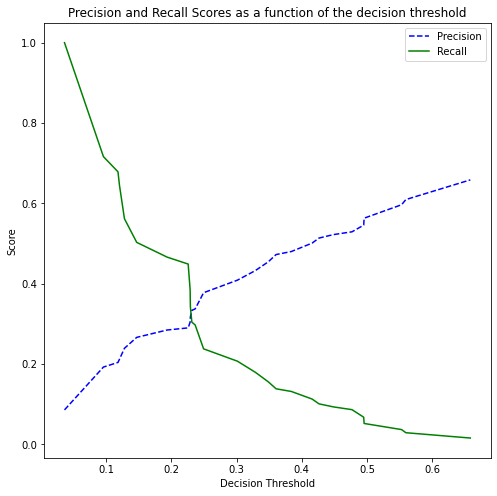

In [181]:
ypred = model.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [182]:
print(confusion_matrix_data(X_train,y_train,model,cutoff=0.2))
print(confusion_matrix_data(X_test,y_test,model,cutoff=0.2))

Accuracy =  85.8202129489204
Precision =  29.005906379477537
FNR =  55.10733127160269
TPR or Recall =  44.89266872839731
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     209688.0      24160.0
Actual 1      12117.0       9871.0
 
Accuracy =  86.04574805734924
Precision =  28.90345649582837
FNR =  54.967502321262764
TPR or Recall =  45.032497678737236
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      52609.0       5965.0
Actual 1       2960.0       2425.0
 


**Cost Complexity Pruning**

In [183]:
model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X_train.iloc[:10000, :],y_train.iloc[:10000])# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [184]:
alphas=path['ccp_alphas']
len(alphas)

382

In [185]:
#Grid search to optimize parameter values

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train.iloc[:10000, :], y_train.iloc[:10000])

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 382 candidates, totalling 1910 fits
Best params for recall
{'ccp_alpha': 0.0}


In [186]:
tree = DecisionTreeClassifier(ccp_alpha=0.0,random_state=1)
tree.fit(X_train, y_train)
print(confusion_matrix_data(X_train,y_train,tree,cutoff = 0.2))
print(confusion_matrix_data(X_test,y_test,tree, cutoff = 0.2))

Accuracy =  99.52899513750997
Precision =  94.88187275946962
FNR =  0.09095870474804439
TPR or Recall =  99.90904129525195
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     232663.0       1185.0
Actual 1         20.0      21968.0
 
Accuracy =  86.06607357838615
Precision =  22.074425969912905
FNR =  74.11327762302693
TPR or Recall =  25.886722376973072
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      53653.0       4921.0
Actual 1       3991.0       1394.0
 


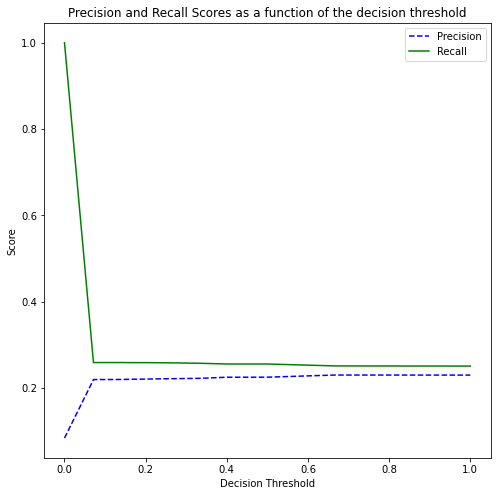

In [187]:
ypred = tree.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

# Random forests

**Categorical Age**

In [314]:
recall = [0]*5

In [315]:
i = 0
start_time = time.time()

for pr in range(10, 15):
    model = RandomForestClassifier(random_state = 1, oob_score = True, verbose = False, 
                                   n_estimators = 500, max_features = pr, 
                                   n_jobs = -1).fit(X_train, y_train)
    oob_pred = model.oob_decision_function_[:, 1]
    bins = np.array([0, 0.5, 1])
    cm = np.histogram2d(y_train, oob_pred, bins = bins)[0]
    recall[i] = 100*(cm[1, 1]) / (cm[1, 0] + cm[1, 1])
    i += 1
    
end_time = time.time()

#took 0.2 min for range of 5 and 4000 obs
print('Time taken = ', (end_time-start_time)/60, 'min')
print('max recall = ', np.max(recall) + 10)
print('Best value of max_features = ', np.argmax(recall) + 10)

Time taken =  0.18982399702072145 min
max recall =  87.65
Best value of max_features =  12


In [318]:
model_rf = RandomForestClassifier(random_state = 1, n_jobs = -1, max_features = 12, 
                                  n_estimators = 500).fit(X_train, y_train)

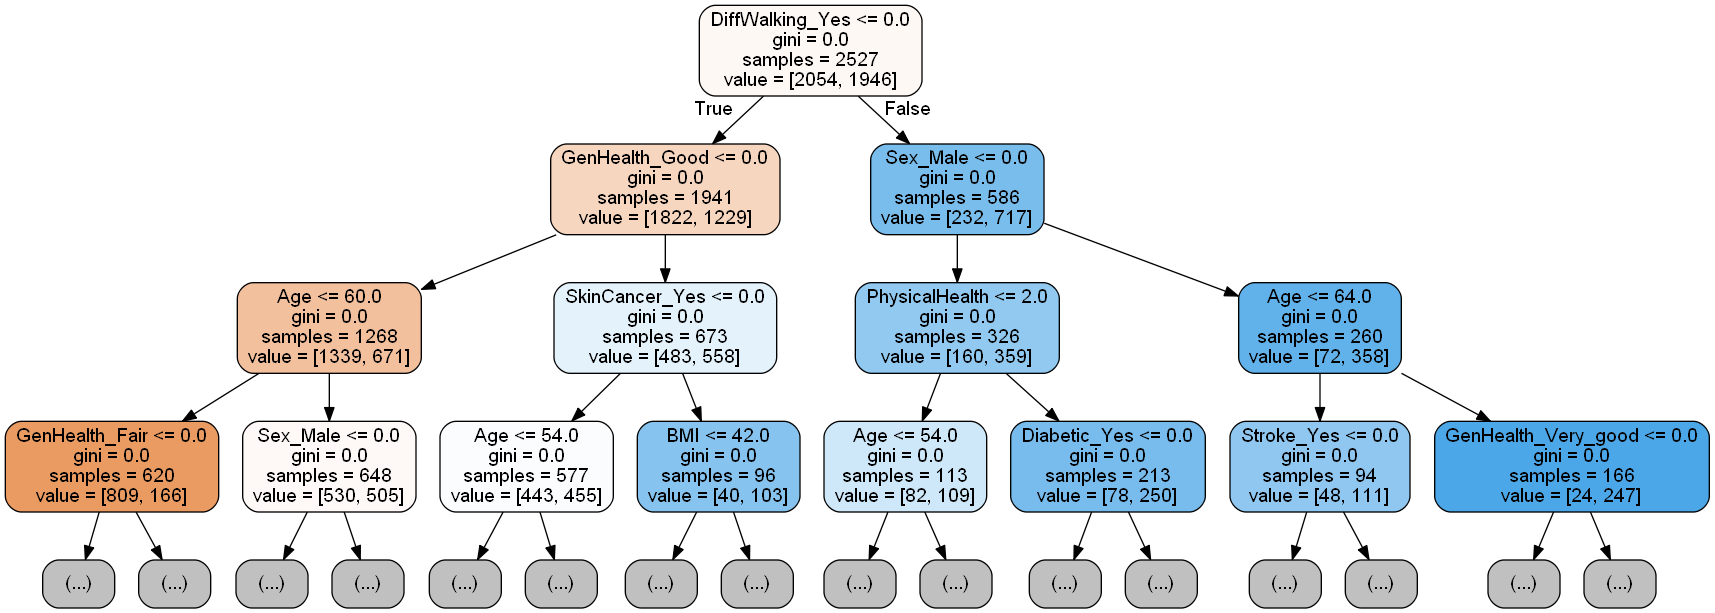

In [320]:
dot_data = StringIO()
export_graphviz(model_rf.estimators_[0], out_file = dot_data, 
                filled = True, rounded = True, max_depth = 3, 
                feature_names = X_train.columns, precision=0)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('car_price_tree.png')
Image(graph.create_png())

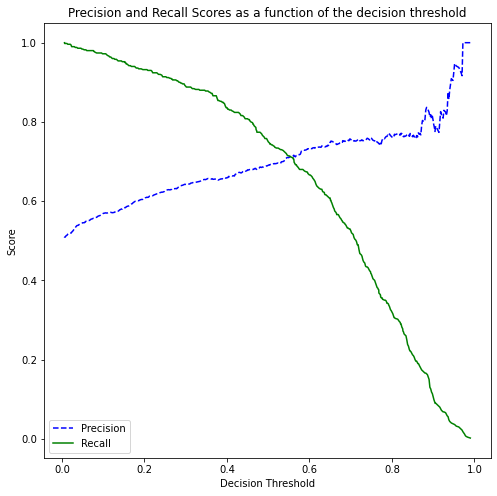

In [321]:
ypred = model_rf.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [327]:
confusion_matrix_data(X_train, y_train, model_rf, 0.4)

Accuracy =  99.875
Precision =  99.75062344139651
FNR =  0.0
TPR or Recall =  100.0
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1995.0          5.0
Actual 1          0.0       2000.0


' '

In [334]:
confusion_matrix_data(X_test, y_test, model_rf, 0.4)

Accuracy =  70.2
Precision =  65.93059936908517
FNR =  16.4
TPR or Recall =  83.6
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        284.0        216.0
Actual 1         82.0        418.0


' '

- Using cutoff = 0.4, accuracy decreases 0.5%, precision decreases 3%, but recall improves by 8% 

**Using X_train2**

In [335]:
model_rf2 = RandomForestClassifier(random_state = 1, n_jobs = -1, max_features = 12, 
                                  n_estimators = 500).fit(X_train2, y_train2)

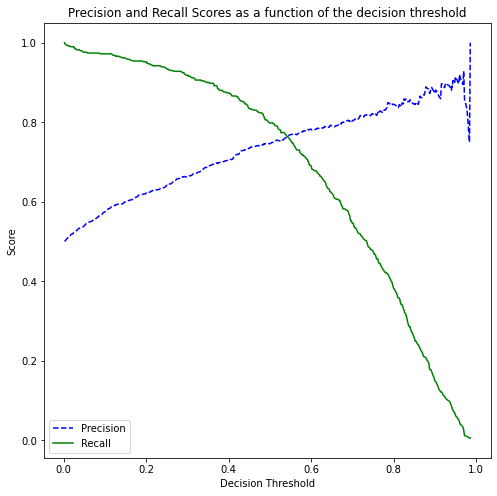

In [341]:
ypred = model_rf2.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [350]:
confusion_matrix_data(X_train2, y_train2, model_rf2, 0.5)

Accuracy =  99.775
Precision =  99.79989994997499
FNR =  0.25
TPR or Recall =  99.75
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1996.0          4.0
Actual 1          5.0       1995.0


' '

In [349]:
confusion_matrix_data(X_test, y_test, model_rf2, 0.5)

Accuracy =  76.3
Precision =  74.57943925233644
FNR =  20.2
TPR or Recall =  79.8
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        364.0        136.0
Actual 1        101.0        399.0


' '

# AdaBoost

In [44]:
#tuning params
start_time = time.time()

model_ab = AdaBoostClassifier(random_state = 1)
grid = dict()
grid['n_estimators'] = [10, 50, 100, 200, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth = 1), DecisionTreeClassifier(max_depth = 2), 
                          DecisionTreeClassifier(max_depth = 3), DecisionTreeClassifier(max_depth = 4)]

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search = GridSearchCV(estimator = model_ab, param_grid = grid, n_jobs = -1, 
                           cv = cv, scoring = ['precision', 'recall', 'accuracy'], refit = 'recall')
grid_result = grid_search.fit(X_train.iloc[:1000], y_train.iloc[:1000])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Best: 0.223529 using {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1.0, 'n_estimators': 100}
Time taken =  1.7052798986434936  minutes


- took 1.7 minutes with 1000 obs

In [46]:
#creating model with optimal params
model_ab = AdaBoostClassifier(random_state = 1, base_estimator = DecisionTreeClassifier(max_depth = 2), 
                             learning_rate = 1.0, n_estimators = 100).fit(X_train.iloc[:10000], y_train.iloc[:10000])

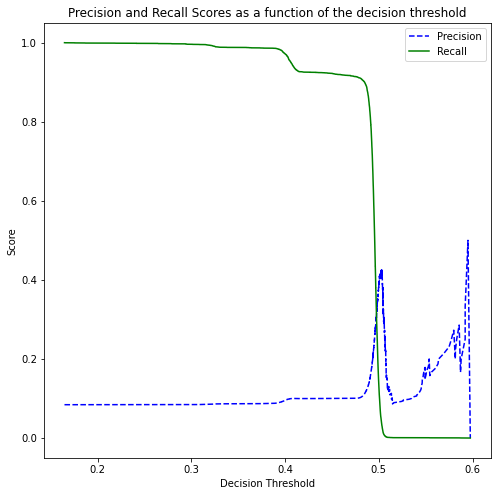

In [47]:
ypred = model_ab.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [49]:
confusion_matrix_data(X_train, y_train, model_ab, 0.5)

Accuracy =  90.75579668224957
Precision =  38.88740304894357
FNR =  86.77460432963434
TPR or Recall =  13.225395670365653
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     229278.0       4570.0
Actual 1      19080.0       2908.0


' '

In [51]:
confusion_matrix_data(X_test, y_test, model_ab, 0.5)

Accuracy =  90.88947607060773
Precision =  38.29449152542373
FNR =  86.57381615598885
TPR or Recall =  13.426183844011142
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      57409.0       1165.0
Actual 1       4662.0        723.0


' '

# Gradient Boosting

In [52]:
#tuning params
start_time = time.time()

model_gb = GradientBoostingClassifier(random_state = 1, max_features = 'sqrt')
grid = dict()
grid['n_estimators'] = [10, 50, 100, 200, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['max_depth'] = [1, 2, 3, 4, 5]
grid['subsample'] = [0.5, 1.0]

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search = GridSearchCV(estimator = model_gb, param_grid = grid, n_jobs = -1, 
                           cv = cv, scoring = ['precision', 'recall', 'accuracy'],
                           refit = 'recall')
grid_result = grid_search.fit(X_train.iloc[:1000], y_train.iloc[:1000])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Best: 0.458824 using {'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.5}
Time taken =  1.3608951171239216  minutes


- took 1.36 min using 1000 obs

In [53]:
model_gb = GradientBoostingClassifier(random_state = 1, max_depth = 1, learning_rate = 1.0, 
                                      n_estimators = 100, subsample = 0.5).fit(X_train.iloc[:10000], y_train.iloc[:10000])

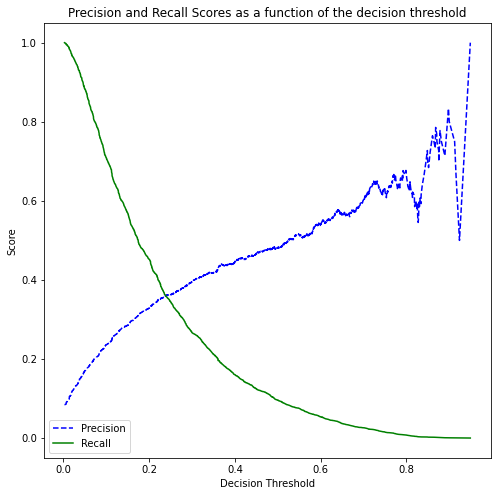

In [54]:
ypred = model_gb.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [58]:
confusion_matrix_data(X_train, y_train, model_gb, 0.2)

Accuracy =  87.33211901374318
Precision =  32.378504514863536
FNR =  56.458068037111154
TPR or Recall =  43.541931962888846
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0     213853.0      19995.0
Actual 1      12414.0       9574.0


' '

In [59]:
confusion_matrix_data(X_test, y_test, model_gb, 0.2)

Accuracy =  87.62957519661033
Precision =  32.92336802270577
FNR =  54.76323119777159
TPR or Recall =  45.23676880222841
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      53611.0       4963.0
Actual 1       2949.0       2436.0


' '